In [ ]:
# 코랩에서 테스트 
import yfinance as yf
import pandas as pd

# 삼성전자(005930.KQ)의 과거 주가 데이터 가져오기
df = yf.download('005930.KQ', start='2015-01-01', end='2024-01-01')
df = df[['Close']]  # 종가(Close)만 사용
print(df.tail())
# df  전체는 Date      Open    High     Low    Close    Volume 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0,1)) 
df_scaled = scaler.fit_transform(df)

train_size = int(len(df_scaled) * 0.8)
train_data, test_data = df_scaled[:train_size], df_scaled[train_size:]


def create_sequences(data, seq_length=50):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length]) 
        y.append(data[i+seq_length])   
    return np.array(x), np.array(y)    

seq_length = 50
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

#                     LSTM 입력 형식 (samples, timesteps, features)
#                                   (배치 크기, 시퀀스 길이, 특성 수)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2), #과적합 방지를 위해 20% 뉴런을 무작위로 비활성화
    LSTM(units=50, return_sequences=True), 
    Dropout(0.2),
    LSTM(units=50),  
    Dropout(0.2),
    Dense(units=1)  # Dens층이 출력층 역할 (주가 예측값) : 최종 출력 노드는 1개 (주가 예측)
])


model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

In [ ]:
#모델 학습 (한 번에 32개 데이터 학습, 데이터를 20번 반복 학습(에포크))
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


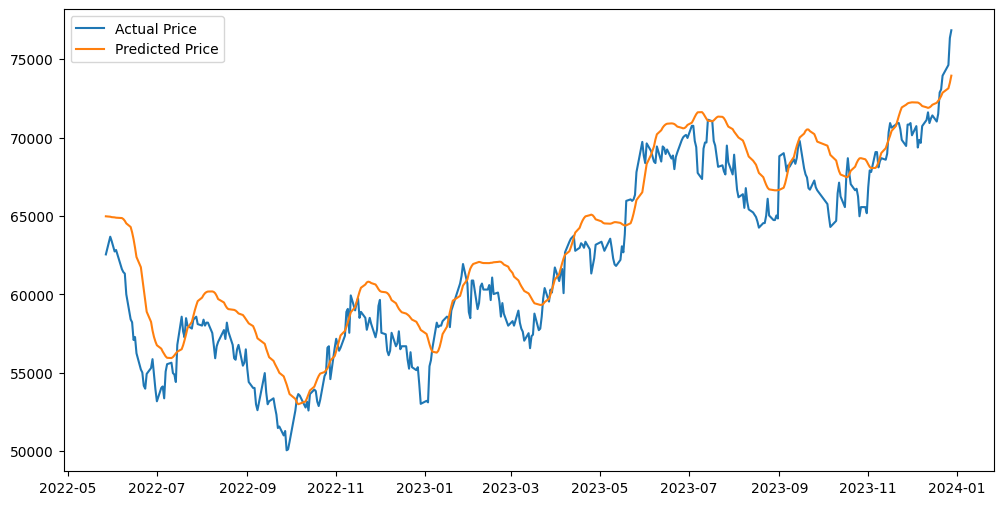

In [ ]:
#예측 및 성능 평가
predicted = model.predict(x_test)
predicted = scaler.inverse_transform(predicted)  

# 실제 가격과 비교
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + seq_length:], scaler.inverse_transform(y_test.reshape(-1, 1)), label="Actual Price")
plt.plot(df.index[train_size + seq_length:], predicted, label="Predicted Price")
plt.legend()
plt.show()